# PEL 215 - Tarefa 02

Discente: Fábio Rossatti Gianzanti

Docente: Prof. Dr. Flávio Tonidandel

O desafio está dividido em 2 partes:
1. Na primeira etapa, usando o robot Youbot, da Kuka, com rodas mecanum, é necessário percorrer um trajeto hexagonal, voltando ao local do início do trajeto, dentro do simulador Webots. Não foi fornecida nenhuma arena específica.

2. A próxima etapa consiste em distribuir uma série de obstaculos em uma arena (não fornecida) e fazer com que o robot alcance um destino (não pré-definido), usando a técnica de navegação por campos potenciais, também dentro do simulador Webots

Links para a visualização dos vídeos demonstrativos:

PARTE 1: TRAJETO HEXAGONAL: <https://youtu.be/TZ6NdUCAA0Q>

PARTE 2: CAMPOS POTENCIAIS: <https://youtu.be/MfiTR4e09Zw>


Link para visualização do código:

GitHub: <https://github.com/Gianzanti/PEL215_TASK_02>

## Estratégia da solução

### Etapa 1 - Movimentação Hexagonal - Classe MecanumRobot

Para cumprir a primeira etapa foi necessário inicialmente definir a movimentação do robo de forma adequada. Estudou-se como definir as movimentações necessárias, sem movimentar a frente do robot para a direção do movimento e foi criado uma classe com os métodos necessários.

Essa classe (MecanumRobot) é responsável por inicializar todos os dispositivos disponíveis no robot, definir sua geometria, seus limites e os movimentos disponíveis. É uma classe do tipo abstrata, que prevê sua utilização por meio de herança por outra classe que implemente os métodos abstratos update, move e odometry, que será responsável por atualizar os parâmetros necessários para o correto caminho. 

A única informação externa fornecida a essa classe é a posição inicial do robot (arg: initPos)

A classe MecanumRobot pode ser vista abaixo:

In [ ]:
from abc import ABC, abstractmethod
from controller import Robot

INF = float("+inf")


class MecanumRobot(ABC):
    def __init__(self, initPos: tuple[float, float] = (0.0, 0.0)) -> None:
        self.me = Robot()
        self.timestep = int(self.me.getBasicTimeStep()) * 1
        maxVelocity = 14.81 / 2  # rad/s
        self.wheel_radius = 0.05  # m
        self.max_speed = maxVelocity * self.wheel_radius  # m/s
        self.speed_increment = 0.5 * self.max_speed
        # self.l = {"x": 0.228, "y": 0.158}
        self.v = {"x": 0.0, "y": 0.0}
        self.p = {"x": initPos[0], "y": initPos[1]}
        self.wheels = []
        self.steps = 0
        self.initMotors()

    def initMotors(self):
        for i in range(0, 4):
            self.wheels.append(self.me.getDevice(f"wheel{i+1}"))

        self.set_wheel_speeds([0, 0, 0, 0])

    def set_wheel_speeds(self, speeds):
        for i in range(0, 4):
            self.wheels[i].setPosition(INF)
            self.wheels[i].setVelocity(speeds[i])

    def base_move(self):
        speeds = [
            1 / self.wheel_radius * (self.v["x"] + self.v["y"]),
            1 / self.wheel_radius * (self.v["x"] - self.v["y"]),
            1 / self.wheel_radius * (self.v["x"] - self.v["y"]),
            1 / self.wheel_radius * (self.v["x"] + self.v["y"]),
        ]
        self.set_wheel_speeds(speeds)
        print(f"Speeds: vx: {self.v['x']:2f}[m/s], vy: {self.v['y']:2f}[m/s]")

    def update_position(self):
        self.p["x"] += self.v["x"] * self.timestep / 1000
        self.p["y"] += self.v["y"] * self.timestep / 1000
        print(f'Position: x: {self.p["x"]:2f}[m], y: {self.p["y"]:2f}[m]')

    def move_forward(self, speed):
        self.v["x"] += speed
        self.v["x"] = self.v["x"] if self.v["x"] < self.max_speed else self.max_speed

    def move_forward_left(self, speed):
        self.v["x"] += speed
        self.v["x"] = self.v["x"] if self.v["x"] < self.max_speed else self.max_speed
        self.v["y"] += speed
        self.v["y"] = self.v["y"] if self.v["y"] < self.max_speed else self.max_speed

    def move_forward_right(self, speed):
        self.v["x"] += speed
        self.v["x"] = self.v["x"] if self.v["x"] < self.max_speed else self.max_speed
        self.v["y"] -= speed
        self.v["y"] = self.v["y"] if self.v["y"] > -self.max_speed else -self.max_speed

    def move_backward(self, speed):
        self.v["x"] -= speed
        self.v["x"] = self.v["x"] if self.v["x"] > -self.max_speed else -self.max_speed

    def move_backward_left(self, speed):
        self.v["x"] -= speed
        self.v["x"] = self.v["x"] if self.v["x"] > -self.max_speed else -self.max_speed
        self.v["y"] += speed
        self.v["y"] = self.v["y"] if self.v["y"] < self.max_speed else self.max_speed

    def move_backward_right(self, speed):
        self.v["x"] -= speed
        self.v["x"] = self.v["x"] if self.v["x"] > -self.max_speed else -self.max_speed
        self.v["y"] -= speed
        self.v["y"] = self.v["y"] if self.v["y"] > -self.max_speed else -self.max_speed

    def stop(self):
        self.v["x"] = 0
        self.v["y"] = 0

    def move_left(self, speed):
        self.v["y"] += speed
        self.v["y"] = self.v["y"] if self.v["y"] < self.max_speed else self.max_speed

    def move_right(self, speed):
        self.v["y"] -= speed
        self.v["y"] = self.v["y"] if self.v["y"] > -self.max_speed else -self.max_speed

    @abstractmethod
    def update(self):
        pass

    @abstractmethod
    def move(self):
        pass

    @abstractmethod
    def odometry(self):
        pass

    def run(self):
        while self.me.step(self.timestep) != -1:
            self.update()
            self.move()
            self.odometry()
            self.steps += 1


### Etapa 1 - Movimentação Hexagonal - Classe KukaPath

Essa classe é a responsável por executar o caminho pré-definido para a movimentação hexagonal do robot e herda da classe anterior (MecanumRobot) as capacidades de movimentação.

Essa classe implementa os seguintes métodos:
    - odometry: após a movimentação do robot, aplica as velocidades estabelecidas (durante o timestep) nos eixos X e Y à posição anterior do robot, para definir sua posição atual.
    - move: aplica as velocidades calculadas pelo método update às rodas do robot, conforme o movimento desejado, executando efetivamente sua movimentação;
    - update: consiste de uma máquina de estados responsável por controlar o próximo passo no caminho pré-definido;

A essa classe devem ser fornecidas a posição inicial do robot e a lista com os diversos passos que o robot deve executar.

In [ ]:
from MecanumRobot import MecanumRobot


class KukaPath(MecanumRobot):
    def __init__(self, pos: tuple[float, float], path: list[tuple[float, float]] = []):
        super().__init__(pos)

        self.state = "checking"
        self.path = path
        self.next = 0
        self.target = {"x": pos[0], "y": pos[1]}

    def move(self):
        self.base_move()

    def odometry(self):
        self.update_position()

    def update(self):
        print(f"steps: {self.steps}")
        print(f"state: {self.state}")
        match self.state:
            case "checking":
                checkPosX = abs(self.p["x"] - self.target["x"])
                checkPosY = abs(self.p["y"] - self.target["y"])
                print(f'Position: X:{self.p["x"]}, Y:{self.p["y"]}')
                print(f'Target: X:{self.target["x"]}, Y:{self.target["y"]}')
                print(
                    f"ΔposX: {checkPosX} [{checkPosX < 0.01}] - ΔposY: {checkPosY} [{checkPosY < 0.01}]"
                )

                if checkPosX < 0.01 and checkPosY < 0.01:
                    self.stop()
                    if (self.next + 1) < len(self.path):
                        self.next += 1
                        self.state = "decideMovement"
                        print(f"Going to next step: {self.path[self.next]}")
                    else:
                        self.state = "stopped"

            case "decideMovement":
                Δx = self.path[self.next][0] - round(self.p["x"], 0)
                Δy = self.path[self.next][1] - round(self.p["y"], 0)
                print(f"Δx: {Δx}, Δy: {Δy}")

                if Δx > 0:
                    if Δy > 0:
                        self.move_forward_left(self.speed_increment)
                    elif Δy == 0:
                        self.move_forward(self.speed_increment)
                    elif Δy < 0:
                        self.move_forward_right(self.speed_increment)
                    else:
                        self.stop()

                elif Δx == 0:
                    if Δy > 0:
                        self.move_left(self.speed_increment)
                    elif Δy == 0:
                        self.stop()
                    elif Δy < 0:
                        self.move_right(self.speed_increment)
                    else:
                        self.stop()

                elif Δx < 0:
                    if Δy > 0:
                        self.move_backward_left(self.speed_increment)
                    elif Δy == 0:
                        self.move_backward(self.speed_increment)
                    elif Δy < 0:
                        self.move_backward_right(self.speed_increment)
                    else:
                        self.stop()

                else:
                    self.stop()

                self.target = {"x": self.p["x"] + Δx, "y": self.p["y"] + Δy}
                self.state = "checking"

                print(
                    f'Current Position: {round(self.p["x"], 0)}, {round(self.p["y"], 0)}'
                )
                print(f"Next state: {self.state}")


### Etapa 1 - Movimentação Hexagonal - Youbot Controller

Para o controle do robot foi criado um script em Python que instancia a classe KukaPath e define os parâmetros necessários à movimentação hexagonal.

Para a simulação foi criada uma arena com 4 tiles de 1 m x 1 m (totalizando 4 m x 4 m) e foi posicionada de forma que o ponto central do tile do canto inferior esquerdo corresponda às coordenadas X: 0.0 m e Y :0.0 m.

A posição inicial do robot é definida como X: 1,0 m e Y: 0,0 m

O caminho definido para a movimentação é:
    Passo 1 = X: 1,0 m , Y: 0,0 m
    Passo 2 = X: 2,0 m , Y: 0,0 m
    Passo 3 = X: 3,0 m , Y: 1,0 m
    Passo 4 = X: 3,0 m , Y: 2,0 m
    Passo 5 = X: 2,0 m , Y: 3,0 m
    Passo 6 = X: 1,0 m , Y: 3,0 m
    Passo 7 = X: 0,0 m , Y: 2,0 m
    Passo 8 = X: 0,0 m , Y: 1,0 m
    Passo 9 = X: 1,0 m , Y: 0,0 m

Esse script é então definido como o controlador do robot no simulador Webots (código listado abaixo) e então inicia-se a simulação. O resultado pode ser visto no vídeo<https://youtu.be/TZ6NdUCAA0Q> 

In [ ]:
from KukaPath import KukaPath


if __name__ == "__main__":
    initial_position = (1, 0)
    path = [
        (1, 0),
        (2, 0),
        (3, 1),
        (3, 2),
        (2, 3),
        (1, 3),
        (0, 2),
        (0, 1),
        (1, 0),
    ]
    kuka = KukaPath(initial_position, path)
    kuka.run()

### Etapa 2 - Navegação por Campos Potenciais - Classe PotencialFields

Estabelecida a correta movimentação do robot, agora se faz necessário implementar um método de navegação em que o caminho seja calculado e não pré-definido. Para isso, usou-se a técnica de navegação por campos potenciais.

À essa classe fornece-se a dimensão do campo, onde foi usada as dimensões em metros da area, as coordenadas do objetivo e as coordenadas dos obstáculos. Solicita-se então o cálculo do Campo Potencial de cada célula, fornecendo como parâmetros o Katt (fator de escala positivo do potencial atrativo) e o Krep (fator de escala positivo do potencial repulsivo).

Essa classe também fornece uma visualização gráfica dos campos potenciais.

A classe PotencialFields pode ser vista abaixo:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class PotencialFields:
    def __init__(
        self,
        size: tuple[int, int],
        goal: tuple[int, int],
        obstacles: list[tuple[int, int, int]],
    ) -> None:
        """
        size [Tamanho da arena]: (X units, Y units)

        goal [Coordenada do objetivo]: (X, Y)

        obstacles [Lista das coordenas dos obstáculos]: [(X, Y, radius), ...]
        """
        self.sizeX, self.sizeY = size
        self.coords = np.zeros(size)
        self.goal = goal
        self.obstacles = obstacles

    def attractivePotencial(self, Katt=1):
        ua = np.zeros_like(self.coords)

        for x in range(self.sizeX):
            for y in range(self.sizeY):
                dist = np.sqrt((self.goal[0] - x) ** 2 + (self.goal[1] - y) ** 2)
                ua[x][y] = 0.5 * Katt * dist**2

        return ua

    def repulsionPotencial(self, Krep=50):
        up = np.zeros_like(self.coords)

        for x in range(self.sizeX):
            for y in range(self.sizeY):
                for obstacle in self.obstacles:
                    dist = np.sqrt((obstacle[0] - x) ** 2 + (obstacle[1] - y) ** 2)
                    if dist == 0:
                        up[x][y] += Krep
                    elif dist <= obstacle[2]:
                        up[x][y] += 0.5 * Krep * (1 / dist - 1 / obstacle[2]) ** 2

    def calculatePotencialField(self, Katt=1, Krep=50):
        return self.attractivePotencial(Katt) + self.repulsionPotencial(Krep)

    def showPlot(self, u):
        fig, ax = plt.subplots(figsize=(20, 20))
        plt.imshow(u.T)
        ax.invert_yaxis()

        for x in range(self.sizeX):
            for y in range(self.sizeY):
                text = ax.text(
                    x,
                    y,
                    "{:.1f}".format(u[x, y]),
                    ha="center",
                    va="center",
                    color="w",
                )

        plt.show()


### Etapa 2 - Definição do caminho - Classe PotencialFields

Estabelecida a correta movimentação do robot, agora se faz necessário implementar um método de navegação em que o caminho seja calculado e não pré-definido. Para isso, usou-se a técnica de navegação por campos potenciais.

À essa classe fornece-se a dimensão do campo, onde foi usada as dimensões em metros da area, as coordenadas do objetivo e as coordenadas dos obstáculos. Solicita-se então o cálculo do Campo Potencial de cada célula, fornecendo como parâmetros o Katt (fator de escala positivo do potencial atrativo) e o Krep (fator de escala positivo do potencial repulsivo).

Essa classe também fornece uma visualização gráfica dos campos potenciais.

A classe PotencialFields pode ser vista abaixo:

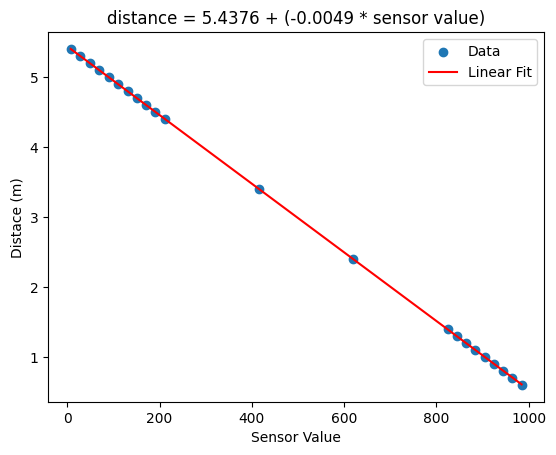

In [5]:
# Load all libs needed
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import interp1d
import pandas as pd

# curve-fit to distance from sensor data

# sensor value (got from webots)
x = np.array([7.2, 27.8, 48.1, 68.7, 89.3, 109.9, 130.5, 150.5, 171.1, 190.5, 212.1, 415, 620, 825, 845, 865, 885, 905, 925, 945, 965, 985])

# distance measured from the robot's centre (got from webots)
y = np.array([5.4,  5.3,  5.2,  5.1,  5.0,   4.9,   4.8,   4.7,   4.6,   4.5,   4.4, 3.4, 2.4, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6])

def linear_func(x,a,b):
  return a + b*x

params, _ = optimize.curve_fit(linear_func, x, y, p0=[1.0, 4.0])

plt.figure()
plt.xlabel('Sensor Value')
plt.ylabel('Distace (m)')
plt.scatter(x, y, label='Data')
plt.plot(x, linear_func(x, params[0], params[1]), 'r', label='Linear Fit')
plt.title(f'distance = {params[0]:.4f} + ({params[1]:.4f} * sensor value)')
plt.legend(loc='best')
plt.show()

2. Foi então elaborado o código do controlador PID (exibido depois dessa introdução) e um código para realizar o tunning do controlador. Esse código foi responsável por capturar os dados de movimentação do robot dentro de uma arena criada somente para essa finalidade, com um largo comprimento, afim de permitir uma captura adequada dos dados, sem que o robot sofresse qualquer interrupção.
    2.1. O primeiro gráfico, visto abaixo, representa o movimento do robot, posicionado a exatos 1.2m da parede lateral direita e com todos os ganhos do controlador PID (Kp, Ki, Kd) zerados, fazendo com que o robo não altere sua posição inicial. Dessa forma, é possível ter uma idéia da variação do valor capturado pelo sonar. É importante notar que o robot não varia sua localização durante esse experimento, entretanto, a resposta dada pelo sonar sofre bastante ruído.

Mean: 1.2132636642104262 - Standard Deviation: 0.03841066629823521


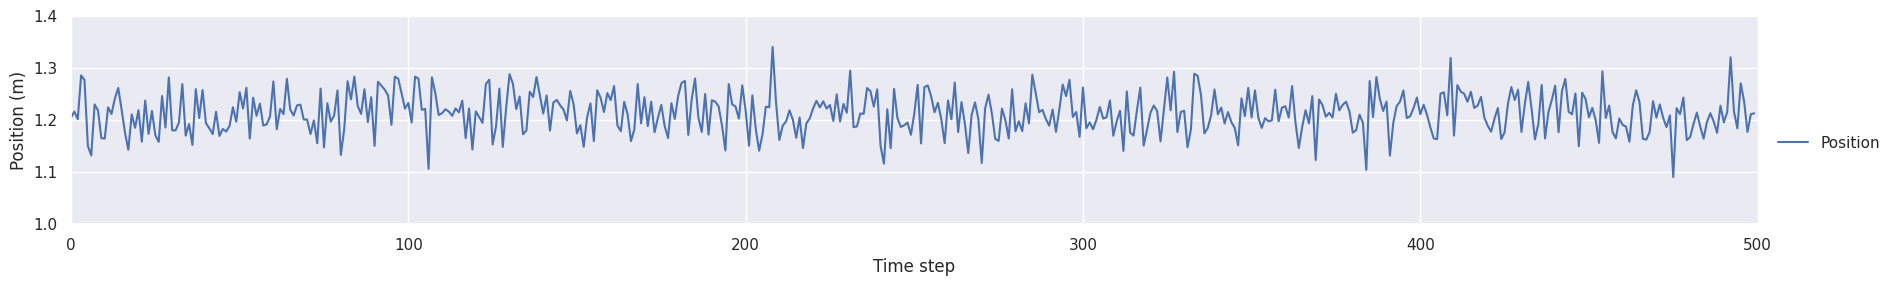

In [9]:
# DEFINE WORK DIRECTORY
workDir = './'

sns.set_theme()

fileName = "p_0_0.npz"

load = np.load(os.path.join(workDir, fileName))

size = 500

data = {'Position': load["position"][:size]}

mean = data['Position'].mean()
std = data['Position'].std()
print(f'Mean: {mean} - Standard Deviation: {std}')

df = pd.DataFrame(data)

sns.relplot(data=df, kind="line", height=3, aspect=6).set(
    xlim=(0, size), ylim=(1.00, 1.40), xlabel="Time step", ylabel="Position (m)"
)

3. Utilizando o conceito do método Ziegler-Nichols para acerto do controlador PID, manteve-se os ganhos Ki e Kd zerados, e passou-se a variar o valor de Kp, em busca do "ultimate gain (Ku)", em que a saída do loop de controle é estável e mantém uma oscilação consistente. Manteve-se a posição inicial do robot em 1.2 m entretanto, o setPoint foi modificado para 1 m;
    3.1. Ajustando o Kp = 1, obteve-se um comportamento errático do robot, sendo descartado;
    3.2. Ajustando o Kp = 0.5, obteve-se também um comportamento inadequado;
    3.3. Vemos abaixo o resultado do Kp = 0.1, que se mostrou razoavelmente adequando, haja visto que as oscilações estavam quase constantes

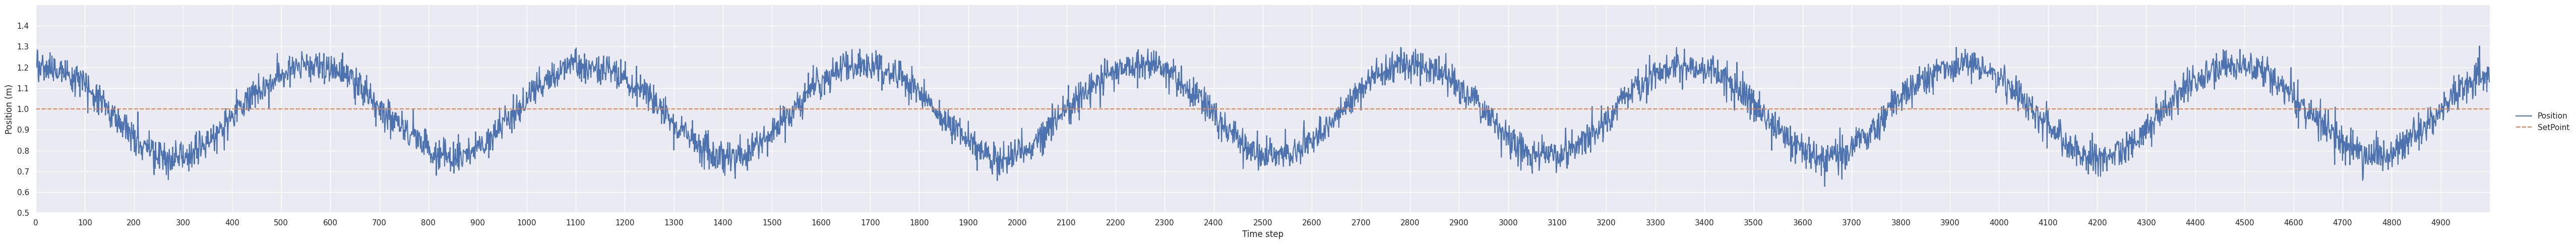

In [13]:
fileName = "p_0_1.npz"
size = 5_000

load = np.load(os.path.join(workDir, fileName))

data = {'Position': load["position"],'SetPoint': load["setPoint"]}

df = pd.DataFrame(data)

yticks = np.arange(0.5, 1.5, 0.1)
xticks = np.arange(0, size, 100)

sns.relplot(data=df, kind="line", height=5, aspect=10).set(
    xlim=(0, size), ylim=(0.5, 1.5), xlabel="Time step", ylabel="Position (m)", yticks=yticks, xticks=xticks
)

    3.4. Com o ajuste do Kp = 0.2, visto abaixo, as oscilações passaram a convergir, então esse valor também foi descartado;

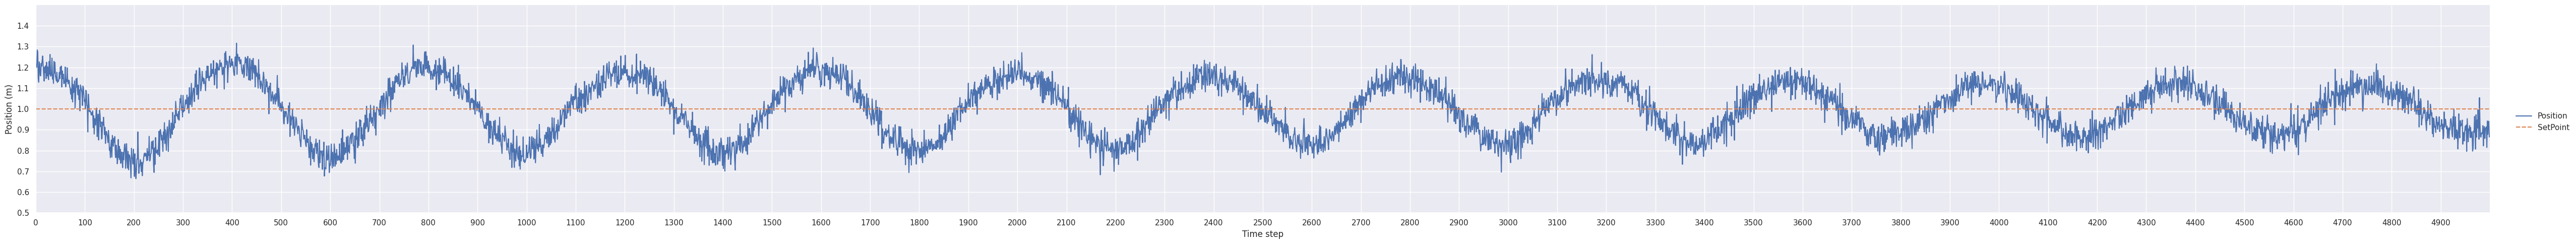

In [15]:
fileName = "p_0_2.npz"
load = np.load(os.path.join(workDir, fileName))
data = {'Position': load["position"],'SetPoint': load["setPoint"]}
df = pd.DataFrame(data)

sns.relplot(data=df, kind="line", height=5, aspect=10).set(
    xlim=(0, size), ylim=(0.5, 1.5), xlabel="Time step", ylabel="Position (m)", yticks=yticks, xticks=xticks
)

    3.5. Ajustando Kp = 0.09, as oscilações também estavam convergindo. Valor também foi descartado;

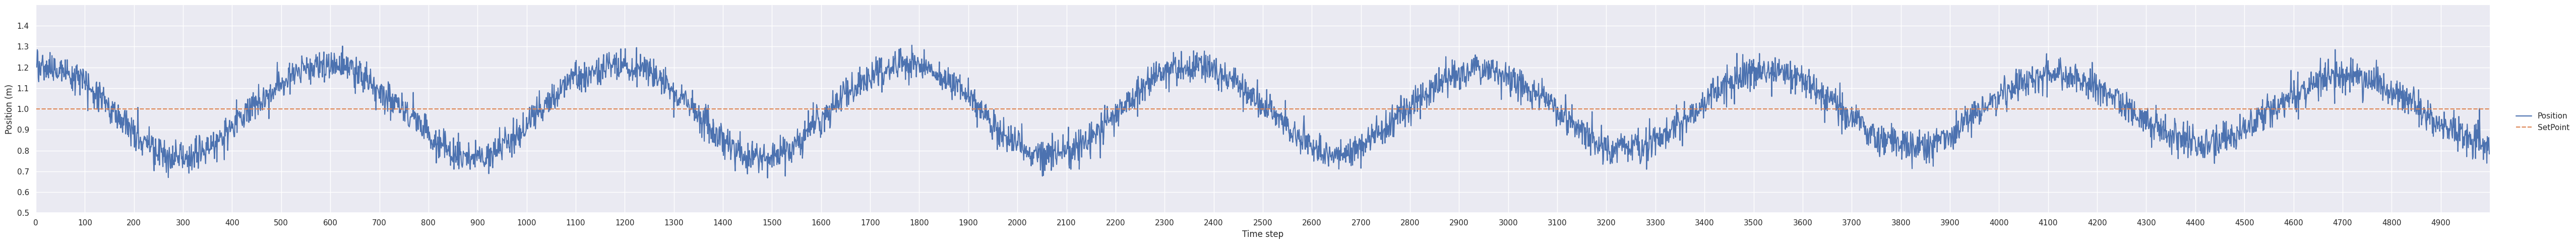

In [16]:
fileName = "p_0_09.npz"
load = np.load(os.path.join(workDir, fileName))
data = {'Position': load["position"],'SetPoint': load["setPoint"]}
df = pd.DataFrame(data)

sns.relplot(data=df, kind="line", height=5, aspect=10).set(
    xlim=(0, size), ylim=(0.5, 1.5), xlabel="Time step", ylabel="Position (m)", yticks=yticks, xticks=xticks
)

    3.6. Finalmente, com Kp = 0.11, chegou-se a um resultado satisfatório das oscilações;

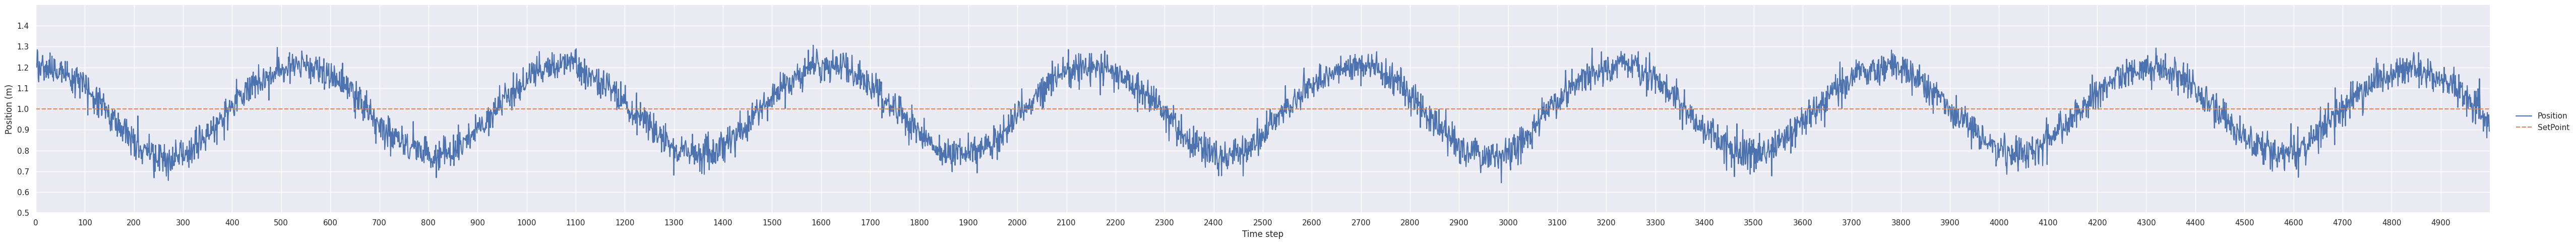

In [17]:
fileName = "p_0_11.npz"
load = np.load(os.path.join(workDir, fileName))
data = {'Position': load["position"],'SetPoint': load["setPoint"]}
df = pd.DataFrame(data)

sns.relplot(data=df, kind="line", height=5, aspect=10).set(
    xlim=(0, size), ylim=(0.5, 1.5), xlabel="Time step", ylabel="Position (m)", yticks=yticks, xticks=xticks
)

4. Com o valor definido de Ku (0.11), realizou-se a medida do período de oscilação da onda, fazendo uma média de 8 ciclos. Com isso temos que Tu = 4325 / 8 = 540.625. Como cada timestep da simulação está definido em 64 ms, defini-se então que Tu = 540.625 * (64/1000) = 34.6 s

5. Com os valores de Ku e Tu podemos então definir os valores de Kp, Ki e Kd:
        Kp = 0.60 * Ku   = 0.066
        Ki = 2 * Kp / Tu = 0.00368
        Kd = Kp * Tu / 8 = 0.29568

6. No gráfico abaixo podemos ver o resultado desses valores de ganho aplicados à simulação. É importante notar que o apesar de ter sido alcançado um steady-state quase zerado, não foi possível melhorar os tempos de subida e de estabilização, que comprometem um pouco no correto funcionamento dentro da arena proposta, pois ocorrem diversas variações do setpoint no decorrer do percurso. Essas dificuldades foram transpostas usando técnicas para detecção de paredes frontais e, nesse caso, obrigando um giro "parado" do robot.

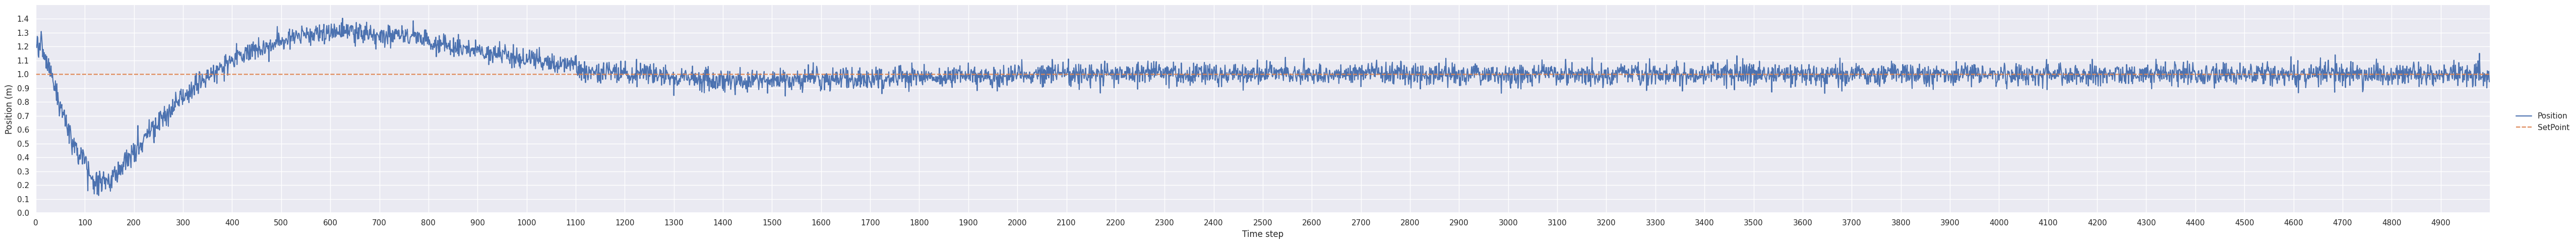

In [20]:
fileName = "p_0_066.npz"
load = np.load(os.path.join(workDir, fileName))

# data = {'Position': load["position"],'SetPoint': load["setPoint"], 'Error': load['error'], 'Speed': load['rightWheelSpeed']}
data = {'Position': load["position"],'SetPoint': load["setPoint"]}

df = pd.DataFrame(data)

yticks = np.arange(0.0, 1.5, 0.1)
xticks = np.arange(0, size, 100)

sns.relplot(data=df, kind="line", height=5, aspect=10).set(
    xlim=(0, size), ylim=(0.0, 1.5), xlabel="Time step", ylabel="Position (m)", yticks=yticks, xticks=xticks
)

# Códigos

## Controlador PID

In [ ]:
class PID:
    def __init__(self, Kp, Ki, Kd, outMax, outMin, lim_int_min, lim_int_max, T, τ):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd

        # Derivative low-pass filter time constant
        self.τ = τ

        # Sample time (in seconds)
        self.T = T

        # Output limits
        self.outMax = outMax
        self.outMin = outMin

        # Integrator limits
        self.lim_int_min = lim_int_min
        self.lim_int_max = lim_int_max

        self.reset()

    def reset(self):
        self.integrator = 0
        self.previous_error = 0

        self.differentiator = 0
        self.previous_measurement = 0

        self.pid = 0

    def update(self, setPoint, measurement):
        error = setPoint - measurement

        proportional = self.Kp * error

        self.integrator += 0.5 * self.Ki * self.T * (error + self.previous_error)

        # Anti-wind-up via integrator clamping
        if self.integrator > self.lim_int_max:
            self.integrator = self.lim_int_max
        elif self.integrator < self.lim_int_min:
            self.integrator = self.lim_int_min

        self.differentiator = -(
            2.0 * self.Kd * (measurement - self.previous_measurement)
        ) + (2.0 * self.τ - self.T) * self.differentiator / (2.0 * self.τ + self.T)

        self.pid = proportional + self.integrator + self.differentiator

        # Output limits
        if self.pid > self.outMax:
            self.pid = self.outMax
        elif self.pid < self.outMin:
            self.pid = self.outMin

        self.previous_measurement = measurement
        self.previous_error = error

        return self.pid


## Pionner Controller

In [ ]:
import math
import numpy as np
from controller import Robot
from pid import PID

INF = float("+inf")


def max_ignore_nan(arr):
    content = list(filter(lambda x: not math.isnan(x), arr))
    if (len(content)) == 0:
        return None
    return max(content)


class MyRobot:
    def __init__(self) -> None:
        self.me = Robot()
        self.timestep = int(self.me.getBasicTimeStep()) * 2
        print(f"Time step: {self.timestep}")
        self.max_speed = 6.4  # => 0.7 m/s
        self.regular_speed = 5  # => 0.5 m/s
        self.speed_factor = 0.5
        self.default_speed = self.speed_factor * self.regular_speed

        self.r_Distance = 1.2

        Ku = 0.11
        # 4325 / 8 = 540.625
        Tu = 540.625 * self.timestep / 1000

        # self.Kp = 0.15
        self.Kp = 0.60 * Ku
        self.Ki = 2 * self.Kp / Tu
        self.Kd = self.Kp * Tu / 8

        # self.Kp = 0.12
        # self.Ki = 0.0
        # self.Kd = 0.0

        print(f"Kp: {self.Kp}")
        print(f"Ki: {self.Ki}")
        print(f"Kd: {self.Kd}")

        self.control_rightDistance = PID(
            Kp=self.Kp,
            Ki=self.Ki,
            Kd=self.Kd,
            outMax=self.speed_factor,
            outMin=-self.speed_factor,
            lim_int_min=-self.max_speed,
            lim_int_max=self.max_speed,
            T=self.timestep / 1000,
            τ=1 / (10 * self.timestep / 1000),
        )

        self.initMotors()
        self.initSensors()

    def initMotors(self):
        self.front_left_motor = self.me.getDevice("front left wheel")
        self.front_right_motor = self.me.getDevice("front right wheel")
        self.back_left_motor = self.me.getDevice("back left wheel")
        self.back_right_motor = self.me.getDevice("back right wheel")

        self.front_left_motor.setPosition(INF)
        self.front_right_motor.setPosition(INF)
        self.back_left_motor.setPosition(INF)
        self.back_right_motor.setPosition(INF)

        self.front_left_motor.setVelocity(0.0)
        self.front_right_motor.setVelocity(0.0)
        self.back_left_motor.setVelocity(0.0)
        self.back_right_motor.setVelocity(0.0)

    def initSensors(self):
        self.sensors = [
            {
                "name": "so0",
                "sensor": self.me.getDevice("so0"),
                "type": "front",
                "position": 0,
                "value": 0,
                "meters": float("NaN"),
            },
            {
                "name": "so1",
                "sensor": self.me.getDevice("so1"),
                "type": "front",
                "position": 40,
                "value": 0,
                "meters": float("NaN"),
            },
            {
                "name": "so2",
                "sensor": self.me.getDevice("so2"),
                "type": "front",
                "position": 60,
                "value": 0,
                "meters": float("NaN"),
            },
            {
                "name": "so3",
                "sensor": self.me.getDevice("so3"),
                "type": "front",
                "position": 80,
                "value": 0,
                "meters": float("NaN"),
            },
            {
                "name": "so4",
                "sensor": self.me.getDevice("so4"),
                "type": "front",
                "position": 100,
                "value": 0,
                "meters": float("NaN"),
            },
            {
                "name": "so5",
                "sensor": self.me.getDevice("so5"),
                "type": "front",
                "position": 120,
                "value": 0,
                "meters": float("NaN"),
            },
            {
                "name": "so6",
                "sensor": self.me.getDevice("so6"),
                "type": "front",
                "position": 140,
                "value": 0,
                "meters": float("NaN"),
            },
            {
                "name": "so7",
                "sensor": self.me.getDevice("so7"),
                "type": "front",
                "position": 180,
                "value": 0,
                "meters": float("NaN"),
            },
            {
                "name": "so8",
                "sensor": self.me.getDevice("so8"),
                "type": "back",
                "position": 180,
                "value": 0,
                "meters": float("NaN"),
            },
            {
                "name": "so9",
                "sensor": self.me.getDevice("so9"),
                "type": "back",
                "position": 180,
                "value": 0,
                "meters": float("NaN"),
            },
            # {
            #     "name": "so10",
            #     "sensor": self.me.getDevice("so10"),
            #     "type": "back",
            #     "position": 180,
            #     "value": 0,
            #     "meters": float("NaN"),
            # },
        ]
        for item in self.sensors:
            item["sensor"].enable(self.timestep)

    def readSensors(self):
        for item in self.sensors:
            item["value"] = item["sensor"].getValue()
            distance = (
                -5e-03 * item["sensor"].getValue() + 5.0
                if item["sensor"].getValue() != 0
                else float("NaN")
            )
            item["meters"] = round(distance, 3)
            # if not math.isnan(distance):
            #     print(
            #         f"{item['name']}: {item['value']:.2f} {item['meters']:.2f} ", end=""
            #     )

        # print("")

    def applySpeed(self):
        # print(f"Left Speed: {self.left_speed}")
        # print(f"Right Speed: {self.right_speed}")
        self.front_left_motor.setVelocity(self.left_speed)
        self.back_left_motor.setVelocity(self.left_speed)
        self.front_right_motor.setVelocity(self.right_speed)
        self.back_right_motor.setVelocity(self.right_speed)

    def rotate(self, angle):
        # to rotate 90 degrees needs 64 steps
        # 1. calculate the number of steps needed to rotate
        # print(f"Angle: {angle}")
        steps = int(abs(angle) * 64 / (math.pi / 2))
        # print(f"Steps: {steps}")
        velocity = 1
        if angle < 0:
            velocity = -1
        self.right_speed = velocity
        self.left_speed = -velocity
        currentStep = 0
        self.applySpeed()
        while currentStep < steps:
            self.me.step(self.timestep)
            currentStep += 1

        self.right_speed = 0
        self.left_speed = 0
        self.applySpeed()

    def checkFrontWall(self):
        distanceA = max_ignore_nan(
            [
                self.sensors[3]["meters"],
                self.sensors[4]["meters"],
            ]
        )

        distanceB = max_ignore_nan(
            [
                self.sensors[5]["meters"],
            ]
        )

        if distanceA != None:
            distance = distanceA * 1.1
            print(f"Main Front Distance: {distance} m")
            return distance
        elif distanceB != None:
            distance = distanceB * 2
            print(f"Auxiliar Front Distance: {distance} m")
            return distance
        else:
            return None

    def faceWall(self):
        # check front alignment
        front_alignment = self.sensors[3]["value"] - self.sensors[4]["value"]
        # print(f"Front alignment: {front_alignment}")

        if abs(front_alignment) < 15 and (
            self.sensors[3]["value"] > 0 or self.sensors[4]["value"] > 0
        ):
            # print("Front aligned...")
            distance = self.checkFrontWall()
            # print(
            #     f"Distance FW: {distance} m *****************************************"
            # )

            if distance <= self.r_Distance:
                self.rotate(math.radians(89))
                return True
            else:
                self.left_speed = self.default_speed
                self.right_speed = self.default_speed

        else:  # check where to turn to align
            left_side = max_ignore_nan(
                [
                    self.sensors[1]["value"],
                    self.sensors[2]["value"],
                    # self.sensors[3]["value"],
                ]
            )
            left_side = left_side if left_side != None else 0

            right_side = max_ignore_nan(
                [
                    # self.sensors[4]["value"],
                    self.sensors[5]["value"],
                    self.sensors[6]["value"],
                ]
            )
            right_side = right_side if right_side != None else 0

            diff = right_side - left_side

            # print(f"Right side: {right_side}")
            # print(f"Left side: {left_side}")
            # print(f"Diff: {diff}")

            if abs(diff) > 45:
                if diff > 0:
                    self.left_speed = self.default_speed
                    self.right_speed = -self.default_speed
                    # print("Turning right...")
                else:
                    self.left_speed = -self.default_speed
                    self.right_speed = self.default_speed
                    # print("Turning left...")

            self.applySpeed()
        return False

    def checkRightWall(self):
        distance = max_ignore_nan(
            [
                self.sensors[6]["meters"],
                self.sensors[7]["meters"],
            ]
        )
        if distance != None:
            print(f"Right Distance: {distance}m")
            return distance
        else:
            print(f"Right Distance > 5.5m")
            return None

    def alignToRightWall(self):
        right_alignment = self.sensors[7]["value"] - self.sensors[8]["value"]

        if abs(right_alignment) < 1 and (
            self.sensors[7]["value"] > 0 or self.sensors[8]["value"] > 0
        ):
            distance = self.checkRightWall()
            return True

        else:
            front = self.sensors[7]["value"]
            front = front if front != None else 0
            rear = self.sensors[8]["value"]
            rear = rear if rear != None else 0

            diff = front - rear

            if abs(diff) > 0.5:
                if diff > 0:
                    self.left_speed = self.default_speed
                    self.right_speed = -self.default_speed
                else:
                    self.left_speed = -self.default_speed
                    self.right_speed = self.default_speed

        return False

    def detectWallRight(self, setPoint):
        # print(
        #     f'Sensor values: {self.sensors[4]["value"]} | {self.sensors[5]["value"]} | {self.sensors[6]["value"]} | {self.sensors[7]["value"]} | {self.sensors[8]["value"]}'
        # )
        max_sensor = max_ignore_nan(
            [
                self.sensors[6]["meters"],
                self.sensors[7]["meters"],
            ]
        )
        sensor8 = (
            self.sensors[8]["meters"]
            if not math.isnan(self.sensors[8]["meters"])
            else None
        )
        sensor5 = (
            self.sensors[5]["meters"]
            if not math.isnan(self.sensors[5]["meters"])
            else None
        )
        sensor4 = (
            self.sensors[4]["meters"]
            if not math.isnan(self.sensors[4]["meters"])
            else 5
        )
        max_sensor = max_sensor if max_sensor != None else sensor8
        max_sensor = max_sensor if max_sensor != None else sensor5
        max_sensor = max_sensor if max_sensor != None else sensor4

        print(f"Current distance from right wall: {max_sensor}")

        error = self.control_rightDistance.update(
            measurement=max_sensor, setPoint=setPoint
        )
        # print(f"Error: {error}")
        return error

    def getRightDistance(self):
        sensorA = max_ignore_nan(
            [
                self.sensors[6]["meters"],
                self.sensors[7]["meters"],
            ]
        )

        sensorB = max_ignore_nan(
            [
                # self.sensors[4]["meters"],
                self.sensors[5]["meters"],
                self.sensors[8]["meters"],
                self.sensors[9]["meters"],
                # self.sensors[10]["meters"],
            ]
        )

        if sensorA != None:
            return sensorA
        elif sensorB != None:
            return sensorB
        else:
            return 3.0

    def avoidFrontObstacle(self, distance, angle=30):
        mainLeftFront = (
            self.sensors[3]["meters"] * 1.1
            if not math.isnan(self.sensors[3]["meters"])
            else None
        )
        auxLeftFront = (
            self.sensors[2]["meters"] * 1.4
            if not math.isnan(self.sensors[2]["meters"])
            else None
        )

        mainRightFront = (
            self.sensors[4]["meters"] * 1.1
            if not math.isnan(self.sensors[4]["meters"])
            else None
        )
        auxRightFront = (
            self.sensors[5]["meters"] * 1.4
            if not math.isnan(self.sensors[5]["meters"])
            else None
        )

        if mainLeftFront != None and mainRightFront != None:
            if mainLeftFront < distance or mainRightFront < distance:
                diff = mainLeftFront - mainRightFront
                print(f"Diff: {diff}")
                if diff > 0.5:
                    print(f"Main Front Left Distance: {mainLeftFront} m")
                    return -angle
                else:
                    print(f"Main Front Right Distance: {mainRightFront} m")
                    return angle

        elif mainLeftFront != None and mainLeftFront < distance:
            print(f"Main Front Left Distance: {mainLeftFront} m")
            return -angle

        elif mainRightFront != None and mainRightFront < distance:
            print(f"Main Front Right Distance: {mainRightFront} m")
            return angle

        elif auxLeftFront != None and auxRightFront != None:
            if auxLeftFront < distance or auxRightFront < distance:
                diff = auxLeftFront - auxRightFront
                if diff > 0.5:
                    print(f"Aux Front Left Distance: {auxLeftFront} m")
                    return -angle
                else:
                    print(f"Aux Front Right Distance: {auxRightFront} m")
                    return angle

        elif auxLeftFront != None and auxLeftFront < distance:
            print(f"Aux Front Left Distance: {auxLeftFront} m")
            return -angle

        elif auxRightFront != None and auxRightFront < distance:
            print(f"Aux Front Right Distance: {auxRightFront} m")
            return angle

        else:
            print("No front obstacle detected")
            return None

    def run(self):
        state = "get_front_wall"
        while self.me.step(self.timestep) != -1:
            self.readSensors()

            match state:
                case "get_front_wall":
                    # print("Positioning front wall")
                    if self.faceWall():
                        state = "align_to_right"

                case "align_to_right":
                    # print("Aligning to right wall")
                    if self.alignToRightWall():
                        state = "control"

                case "control":
                    # print("Controlling...")

                    setPoint = self.r_Distance
                    position = self.getRightDistance()
                    print(f"Position: {position} m")
                    error = self.control_rightDistance.update(
                        measurement=position, setPoint=setPoint
                    )

                    self.right_speed = self.default_speed
                    self.left_speed = self.default_speed

                    front_obstacle = self.avoidFrontObstacle(setPoint, 46)

                    if front_obstacle != None:
                        self.rotate(math.radians(front_obstacle))
                    else:
                        self.right_speed = (
                            self.speed_factor + error
                        ) * self.regular_speed

                        print(f"Right Speed: {self.right_speed}")

                    self.applySpeed()


if __name__ == "__main__":
    robot = MyRobot()
    robot.run()
